In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import gpflow as gpf
import numpy as np
gpf.config.set_default_float(np.float32)

gpf.config.set_default_jitter(tf.cast(1e-6, dtype=gpf.default_float()))
from onoffgpf import OnOffSVGP, OnOffLikelihood
from onoffgpf.PlotOnOff1D import PlotOnOff1D

from gpflow import conditionals

import gpflow

import scipy.io as sio
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
matdata = sio.loadmat('data/toydata.mat')
Xtrain = matdata['x'].astype(gpf.default_float())
Ytrain = matdata['y'].astype(gpf.default_float())

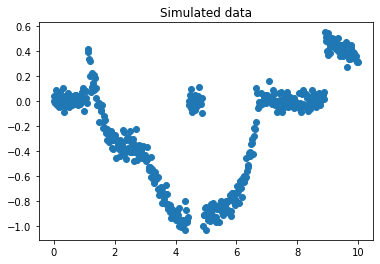

In [3]:
plt.scatter(Xtrain,Ytrain)
plt.title("Simulated data")
plt.show()

In [4]:
num_inducing   = 10

# initalize kernel parameters
kf = gpf.kernels.RBF(variance=1, lengthscales=2)

kg = gpf.kernels.RBF(variance=5, lengthscales=2)

# initialise equally spaced inducing point locations
Zf = np.delete(np.linspace(min(Xtrain),max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1)
Zg = np.delete(np.linspace(min(Xtrain),max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1)

In [5]:
# model definition
m = OnOffSVGP(Xtrain, Ytrain
              ,kernf=kf,kerng=kg
              ,likelihood = OnOffLikelihood()
              ,Zf = Zf,Zg = Zg
             )

# make variance trainable
m.likelihood.variance.assign(0.01)
from gpflow import set_trainable
set_trainable(m.likelihood.variance, True)

In [6]:
N=len(Xtrain)

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(Xtrain,),
                                                    tf.convert_to_tensor(Ytrain,)),)#.repeat().shuffle(N)


In [7]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(
    m.training_loss_closure(compile=True),
    m.trainable_variables,
    options={'maxiter':(80000), 'ftol':1e-64, 'gtol':1e-64, 'factr':-1e-64},
)

/home/kheuton/anaconda3/envs/port_zigp/lib/python3.10/site-packages/gpflow/optimizers/scipy.py:94: OptimizeWarning: Unknown solver options: factr
  return scipy.optimize.minimize(


      fun: -295.13592529296875
 hess_inv: <59x59 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.68061090e+00,  8.62871528e-01, -4.35345173e+00, -5.41515589e+00,
        1.76298118e+00,  4.49194908e-01,  2.94325924e+00, -3.01793337e+00,
        2.67861557e+00, -2.23278141e+00, -6.11668491e+00,  3.12434524e-01,
       -2.59197540e+01, -1.30451660e+01,  1.02930908e+01,  6.51412201e+00,
        4.51358795e+00, -2.82057738e+00,  4.47692871e-01, -4.81334782e+00,
       -6.25806427e+00, -2.31291771e+00,  1.93736076e+00, -5.11544847e+00,
       -2.09070539e+00, -6.42702484e+00,  6.40145874e+00,  2.53650093e+00,
        1.29062283e+00,  1.24546230e+00,  7.80109644e-01,  3.69781554e-01,
        1.27885139e+00,  3.86682153e-02,  7.93270171e-01,  1.18264723e+00,
        9.80136991e-01,  8.93510461e-01, -4.73424084e-02, -7.30457306e-01,
        1.55814743e+00, -1.30808258e+00,  6.77755833e-01,  1.56073570e-01,
       -7.54580259e-01,  1.94832683e-01, -4.17701095e-01, -9.10742044e-01,


In [8]:
def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = train_dataset#iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(compile=True)
    optimizer = tf.optimizers.Adam(learning_rate=0.005)#gpflow.optimizers.Adam(learning_rate=0.01)

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf
logf = run_adam(m, 80000)

In [9]:
logf[-1]

507.469

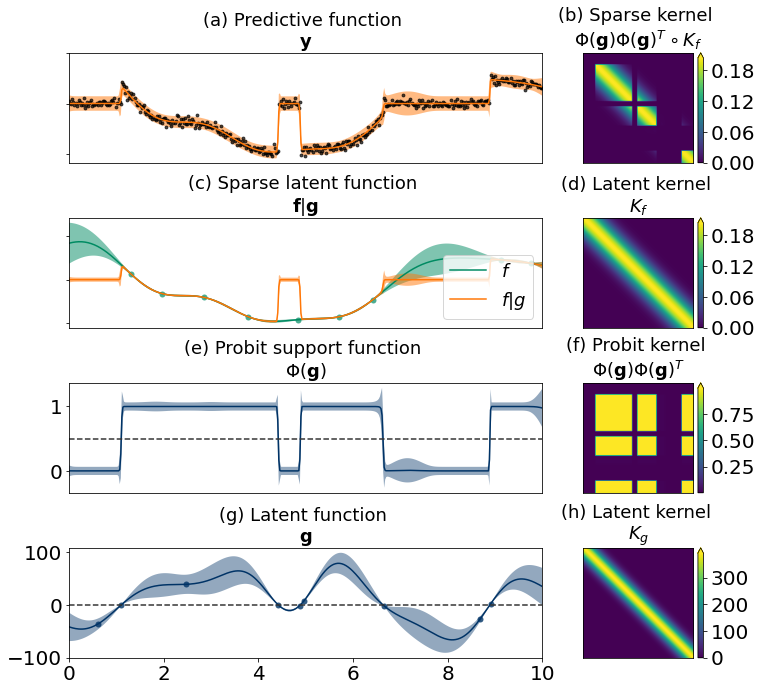

In [10]:
# model plot
PlotOnOff1D(m)

In [11]:
def normcdf(x):
    return 0.5 * (1.0 + tf.math.erf(x / np.sqrt(2.0))) * (1. - 2.e-3) + 1.e-3

In [134]:
num_samples = 100000
data_shape = m.X.shape
u = tf.random.normal(shape=data_shape+(num_samples,))
w = tf.random.normal(shape=data_shape+(num_samples,))
v = tf.random.normal(shape=data_shape+(num_samples,))

In [135]:
fmean, fvar = conditionals.conditional(m.X, m.Zf, m.kernf, m.u_fm,
                                               full_cov=False, q_sqrt=m.u_fs_sqrt, )
fmean = fmean + m.mean_function(m.X)

gmean, gvar = conditionals.conditional(m.X, m.Zg, m.kerng, m.u_gm,
                                       full_cov=False, q_sqrt=m.u_gs_sqrt, )

In [136]:
# Expand dims to give the mean a sample dimension
g_mean_NDS = tf.expand_dims(gmean, -1)
g_std_NDS = tf.expand_dims(tf.math.sqrt(gvar), -1)
g_samples = g_mean_NDS + u*g_std_NDS
phi_g_samples = normcdf(g_samples)

In [137]:
fmean, fvar = conditionals.conditional(m.X, m.Zf, m.kernf, m.u_fm,
                                       full_cov=False, q_sqrt=m.u_fs_sqrt, )
fmean = fmean + m.mean_function(m.X)


In [138]:
# Expand dims to give the mean a sample dimension
f_mean_NDS = tf.expand_dims(fmean, -1)
f_var_NDS = tf.expand_dims(fvar, -1)
f_std_NDS = tf.math.sqrt(f_var_NDS)
f_samples = f_mean_NDS*phi_g_samples + w*f_std_NDS*phi_g_samples


In [139]:
y_normal = tfp.distributions.Normal(loc=f_samples, scale=tf.math.sqrt(m.likelihood.variance))
py = y_normal.log_prob(tf.expand_dims(m.Y,-1))

qf_var_exp = 1/(2*m.likelihood.variance) * phi_g_samples * phi_g_samples * f_var_NDS

In [140]:
alt_py = -np.log(tf.math.sqrt(m.likelihood.variance)) \
- 0.5 *np.log(2*np.pi) - 0.5 * (tf.square(tf.expand_dims(m.Y,-1)- f_samples) )/m.likelihood.variance

In [141]:
np.isclose(alt_py,py).mean()

0.9972540888888889

In [142]:
np.sum(py-alt_py)

1.4669011

In [143]:
elbo_likelihood = alt_py - qf_var_exp

# reduce samples
elbo_likelihood_over_samples = tf.reduce_mean(elbo_likelihood, -1)
# reduce data
elbo_likelihood_over_data = tf.reduce_sum(elbo_likelihood_over_samples)
elbo_likelihood_over_data

<tf.Tensor: shape=(), dtype=float32, numpy=632.4301>

In [144]:
fmean, fvar = conditionals.conditional(m.X, m.Zf, m.kernf, m.u_fm,
                                               full_cov=False, q_sqrt=m.u_fs_sqrt, )
fmean = fmean + m.mean_function(m.X)

gmean, gvar = conditionals.conditional(m.X, m.Zg, m.kerng, m.u_gm,
                                       full_cov=False, q_sqrt=m.u_gs_sqrt, )

# probit transformed expectations for  gamma
ephi_g, ephi2_g, evar_phi_g = m.ProbitExpectations(gmean, gvar)

# compute augmented f
# from above computations we have
# p(f)   = N(f| A*u_fm, Kfnn + A(u_fs - Kfmm)t(A))  A = Kfnm*inv(Kfmm)
# p(f|g) = N(f| diag(ephi_g)* A*u_fm, diag(evar_phi_g)) * (Kfnn + A(u_fs - Kfmm)t(A)))
gfmean = tf.multiply(ephi_g, fmean)
gfvar = tf.multiply(ephi2_g, fvar)
gfmeanu = tf.multiply(evar_phi_g, tf.square(fmean))

var_exp = m.likelihood.variational_expectations(gfmean, gfvar, gfmeanu, m.Y)
tf.reduce_sum(var_exp)

<tf.Tensor: shape=(), dtype=float32, numpy=603.6068>

In [74]:
elbo_likelihood_over_samples

<tf.Tensor: shape=(450, 1), dtype=float32, numpy=
array([[ 1.54247785e+00],
       [ 1.78611779e+00],
       [ 1.75390983e+00],
       [ 9.41110015e-01],
       [ 1.68482935e+00],
       [ 1.70555723e+00],
       [ 1.79510105e+00],
       [ 1.58873034e+00],
       [ 1.83541822e+00],
       [ 1.12412870e+00],
       [ 1.75865638e+00],
       [ 1.65279818e+00],
       [ 1.80716956e+00],
       [ 1.68163872e+00],
       [ 5.89939892e-01],
       [ 8.17449033e-01],
       [ 1.69836581e+00],
       [ 1.66361237e+00],
       [ 1.62245417e+00],
       [ 1.84130347e+00],
       [ 1.71427619e+00],
       [ 1.36034107e+00],
       [ 1.56344235e+00],
       [ 1.83050120e+00],
       [ 1.76707566e+00],
       [ 1.83603370e+00],
       [ 1.80218887e+00],
       [ 1.71587098e+00],
       [ 1.64885604e+00],
       [ 1.78832388e+00],
       [ 1.76733470e+00],
       [ 1.81990778e+00],
       [ 1.54731750e+00],
       [ 1.54170549e+00],
       [ 1.70734656e+00],
       [ 1.83941936e+00],
       [ 1.716

In [61]:
var_exp

<tf.Tensor: shape=(450, 1), dtype=float32, numpy=
array([[ 1.4661322 ],
       [ 1.687917  ],
       [ 1.6632577 ],
       [ 0.8472103 ],
       [ 1.5786418 ],
       [ 1.600247  ],
       [ 1.6915139 ],
       [ 1.4864562 ],
       [ 1.7323849 ],
       [ 1.0223565 ],
       [ 1.6562744 ],
       [ 1.5509415 ],
       [ 1.7059728 ],
       [ 1.5812197 ],
       [ 0.49043286],
       [ 0.7190237 ],
       [ 1.6011171 ],
       [ 1.5677105 ],
       [ 1.5280442 ],
       [ 1.7485346 ],
       [ 1.6232784 ],
       [ 1.271251  ],
       [ 1.4763954 ],
       [ 1.7456161 ],
       [ 1.6844652 ],
       [ 1.755809  ],
       [ 1.7244469 ],
       [ 1.6407115 ],
       [ 1.5763669 ],
       [ 1.7185638 ],
       [ 1.7003841 ],
       [ 1.755814  ],
       [ 1.4861224 ],
       [ 1.4834552 ],
       [ 1.6520526 ],
       [ 1.7870983 ],
       [ 1.6670464 ],
       [ 1.7808882 ],
       [ 1.726584  ],
       [ 1.7639617 ],
       [ 1.5428748 ],
       [ 1.1621873 ],
       [ 1.7020825 ],
    

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib import ticker
import gpflow
import tensorflow as tf
def PlotOnOff1DDebug(m, g_samples, phi_g_samples, y_samples):
    mpl.rcParams['figure.figsize'] = (11.0,10.0)
    mpl.rcParams.update({'font.size': 20})

    _X = m.Xtrain
    _Y = m.Ytrain

    _gfmean,_gfvar,_,_fmean,_fvar,_gmean,_gvar,_pgmean,_pgvar = m.predict_onoffgp(_X)
    _Zf = m.Zf.numpy()
    _Kf = m.kernf.K(_X)
    _u_fm = m.u_fm.numpy()
    _u_fs_sqrt = m.u_fs_sqrt

    _Zg = m.Zg.numpy()
    _Kg = m.kerng.K(_X)
    _u_gm = m.u_gm.numpy()
    _u_gs_sqrt = m.u_gs_sqrt

    _variance = m.likelihood.variance

    _Kpg = tf.reshape(_pgmean,(-1,1)) * tf.reshape(_pgmean, (1,-1))
    _Kfg = _Kpg * _Kf

    _X = _X.flatten()
    _Y = _Y.flatten()
    _gfmean = tf.reshape(_gfmean, -1)
    _gfvar  = tf.reshape(_gfvar, -1)
    _fmean  = tf.reshape(_fmean, -1)
    _fvar   = tf.reshape(_fvar, -1)
    _gmean  = tf.reshape(_gmean, -1)
    _gvar   = tf.reshape(_gvar, -1)
    _pgmean = tf.reshape(_pgmean, -1)
    _pgvar  = tf.reshape(_pgvar, -1)


    gs = gridspec.GridSpec(4, 4)
    ax1 = plt.subplot(gs[0, 0:-1])
    ax2 = plt.subplot(gs[1, 0:-1])
    ax3 = plt.subplot(gs[2, 0:-1])
    ax4 = plt.subplot(gs[3, 0:-1])
    ax5 = plt.subplot(gs[0, -1])
    ax6 = plt.subplot(gs[1, -1])
    ax7 = plt.subplot(gs[2, -1])
    ax8 = plt.subplot(gs[3, -1])
    
    import pdb; pdb.set_trace()
    #print (_gfvar)
    
    #print ((np.sqrt(_fvar) * _pgmean + np.sqrt(_pgvar)*(1-_pgmean)))


    f_residual = tf.squeeze(tf.reduce_mean(f_samples,-1)) - _gfmean

    
    # plot y
    ax1.plot(_X,tf.reduce_mean(f_samples,-1),'-',color='#ff7707')
    ax1.plot(_X, f_residual,'-',color='#ff0000', label='residual')
    y1 = (_gfmean-1.5*((np.sqrt(_fvar) * _pgmean + np.sqrt(_pgvar)*(1-_pgmean)) + np.sqrt(_variance)))
    y2 = (_gfmean+1.5*((np.sqrt(_fvar) * _pgmean +  np.sqrt(_pgvar)*(1-_pgmean)) + np.sqrt(_variance)))
    ax1.fill_between(_X,y1,y2,facecolor='#ff7707',alpha=0.5)
    ax1.scatter(_X,_Y,s=8,
             color='black',alpha=0.7)
    ax1.set_xlim(0,10)
    # ax1.set_ylabel("Data" + r"$\mathbf{y}|\mathbf{f}$")
    ax1.set_title("(a) Predictive function \n"+r"$\mathbf{y}$",fontsize=18)
    ax1.set_yticks([-1,0,1], [])
    ax1.set_xticks([], [])

    # plot f and f|g
    ax2.plot(_X,_fmean,'-',color='#008b62',label=r"$f$")
    f1 = (_fmean-1.5*np.sqrt(_fvar))
    f2 = (_fmean+1.5*np.sqrt(_fvar))
    ax2.fill_between(_X,f1,f2,facecolor='#008b62',alpha=0.5)
    ax2.plot(_Zf,_u_fm,
             marker='o',linestyle = 'None',
             markeredgecolor = 'None',
             markerfacecolor='#008b62',alpha=0.7) #,label = 'uf (optimized)')

    ax2.plot(_X,_gfmean,'-',color='#ff7707',label=r"$f|g$")
    f3 = (_gfmean-1.5*(np.sqrt(_fvar) * _pgmean + np.sqrt(_pgvar)*(1-_pgmean)))
    f4 = (_gfmean+1.5*(np.sqrt(_fvar) * _pgmean + np.sqrt(_pgvar)*(1-_pgmean)))
    ax2.fill_between(_X,f3,f4,facecolor='#ff7707',alpha=0.5)

    ax2.set_xlim(0,10)
    # ax2.set_ylabel("Augmnted "+ r"$\mathbf{f}|\mathbf{g}$",fontsize=18)
    ax2.set_xticks([], [])
    ax2.set_yticks([-1,0,1], [])
    ax2.set_title("(c) Sparse latent function \n"+ r"$\mathbf{f}|\mathbf{g}$",fontsize=18)
    ax2.legend(loc="lower right",ncol=1,fontsize=18)

    # plot phi(gamma)
    ax3.plot(_X,_pgmean,'-',color='#003366')
    pg1 = (_pgmean-2*np.sqrt(_pgvar))
    pg2 = (_pgmean+2*np.sqrt(_pgvar))
    ax3.fill_between(_X,pg1,pg2,facecolor='#6684a3',alpha=0.7)
    ax3.axhline(y=0.5,linestyle='--',color='#333333')
    ax3.set_xlim(0,10)
    ax3.set_title("(e) Probit support function \n" + r"$\Phi(\mathbf{g})$",fontsize=18)
    ax3.set_xticks([], [])
    # ax3.set_ylabel("Support " + r"$\Phi(\mathbf{g})$",fontsize=18)

    # plot gamma
    ax4.plot(_X,_gmean,'-',color='#003366')
    ax4.plot(_Zg,_u_gm,
             marker='o',linestyle = 'None',
             markeredgecolor = 'None',
             markerfacecolor='#003366',alpha=0.8) #,label = 'ug (optimized)')
    g1 = (_gmean-2*np.sqrt(_gvar))
    g2 = (_gmean+2*np.sqrt(_gvar))
    ax4.fill_between(_X,g1,g2,facecolor='#6684a3',alpha=0.7)
    # ax4.set_ylabel("Latent  " +r"$\mathbf{g}$",fontsize=18)
    ax4.axhline(y=0.0,linestyle='--',color='#333333')
    ax4.set_title("(g) Latent function \n" +r"$\mathbf{g}$",fontsize=18)
    ax4.set_xlim(0,10)
    # plt.title('kernel lengthscale = %.3f, variance = %.3f' % (klg,ksg))

    im5 = ax5.imshow(_Kfg,cmap="viridis")
    cb = plt.colorbar(im5,ax=ax5,fraction=0.046, pad=0.03,extend="max")
    ax5.set_title("(b) Sparse kernel \n" + r"$\Phi(\mathbf{g}) \Phi(\mathbf{g})^T \circ K_f$",fontsize=18)
    ax5.set_xticks([], [])
    ax5.set_yticks([], [])
    tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator
    cb.update_ticks()


    im6 = ax6.imshow(_Kf,cmap="viridis")
    cb = plt.colorbar(im6,ax=ax6,fraction=0.046, pad=0.03,extend="max")
    ax6.set_title("(d) Latent kernel \n"+r"$K_f$",fontsize=18)
    ax6.set_xticks([], [])
    ax6.set_yticks([], [])
    tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator
    cb.update_ticks()


    im7 = ax7.imshow(_Kpg,cmap="viridis")
    cb = plt.colorbar(im7,ax=ax7,fraction=0.046, pad=0.03,extend="max")
    ax7.set_title("(f) Probit kernel \n" + r"$\Phi(\mathbf{g}) \Phi(\mathbf{g})^T$",fontsize=18)
    ax7.set_xticks([], [])
    ax7.set_yticks([], [])
    tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator
    cb.update_ticks()


    im8 = ax8.imshow(_Kg,cmap="viridis")
    cb =  plt.colorbar(im8,ax=ax8,fraction=0.046, pad=0.03,extend="max")
    ax8.set_title("(h) Latent kernel \n"+r"$K_g$",fontsize=18)
    ax8.set_xticks([], [])
    ax8.set_yticks([], [])
    tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator
    cb.update_ticks()

    plt.tight_layout()
    plt.subplots_adjust(hspace = 0.5,wspace=0.1)
    plt.savefig("plots/toy.png")
    plt.show()

> /tmp/ipykernel_4109/1937899119.py(59)PlotOnOff1DDebug()
     57 
     58 
---> 59     f_residual = tf.squeeze(tf.reduce_mean(f_samples,-1)) - _gfmean
     60 
     61 

ipdb> continue


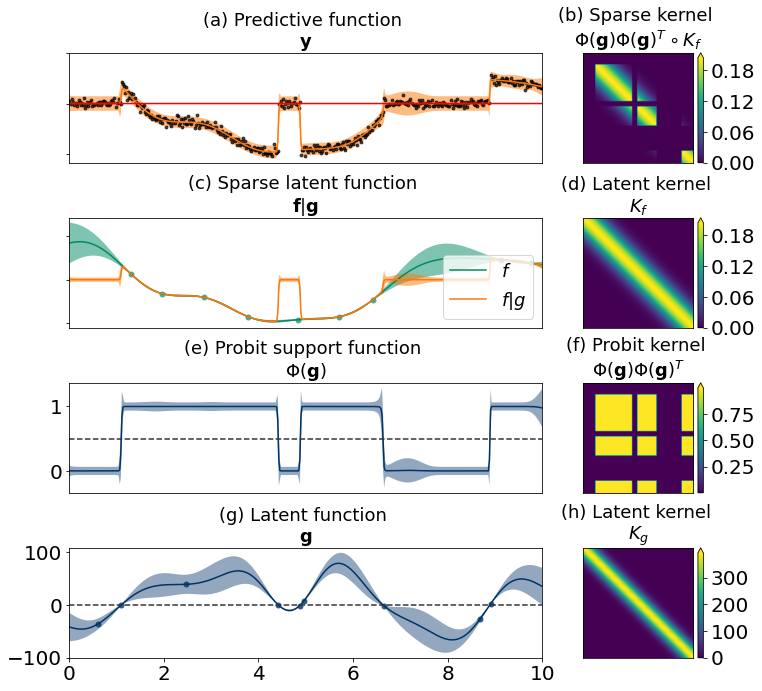

In [75]:
PlotOnOff1DDebug(m, g_samples, phi_g_samples, f_samples)

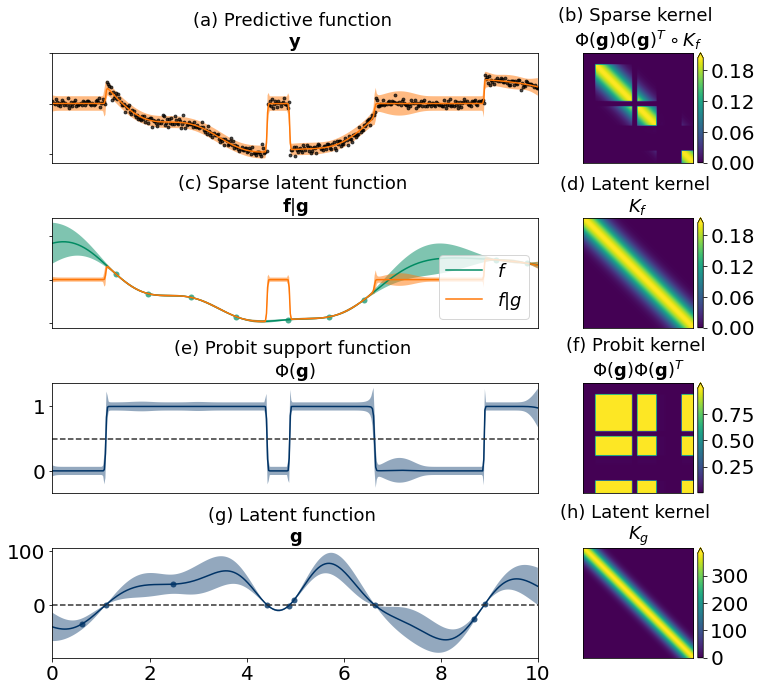

In [78]:
PlotOnOff1D(m)

In [92]:
 m.mean_function(m.X)

<tf.Tensor: shape=(450, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
 

In [32]:
m.build_prior_KL()

<tf.Tensor: shape=(), dtype=float32, numpy=96.09295>

In [78]:
var_exp[3]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8472103], dtype=float32)>

In [81]:
elbo_likelihood_over_samples[3]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.94111], dtype=float32)>

In [84]:
tf.reduce_mean(alt_py[3])

<tf.Tensor: shape=(), dtype=float32, numpy=0.94393575>

In [85]:
tf.reduce_mean(py[3])

<tf.Tensor: shape=(), dtype=float32, numpy=0.9439359>

In [86]:
ephi_g[3]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.00123345], dtype=float32)>

In [87]:
tf.reduce_mean(phi_g_samples[3,:,:])

<tf.Tensor: shape=(), dtype=float32, numpy=0.001308552>

In [98]:
tf.reduce_mean(phi_g_samples * phi_g_samples,-1)[3,:]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0002593], dtype=float32)>

In [101]:
ephi2_g[3]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.00119446], dtype=float32)>

In [102]:
0.001308552*0.001308552

1.7123083367039999e-06

In [103]:
phi_g_samples[3,:,:]

<tf.Tensor: shape=(1, 100000), dtype=float32, numpy=array([[0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001]], dtype=float32)>

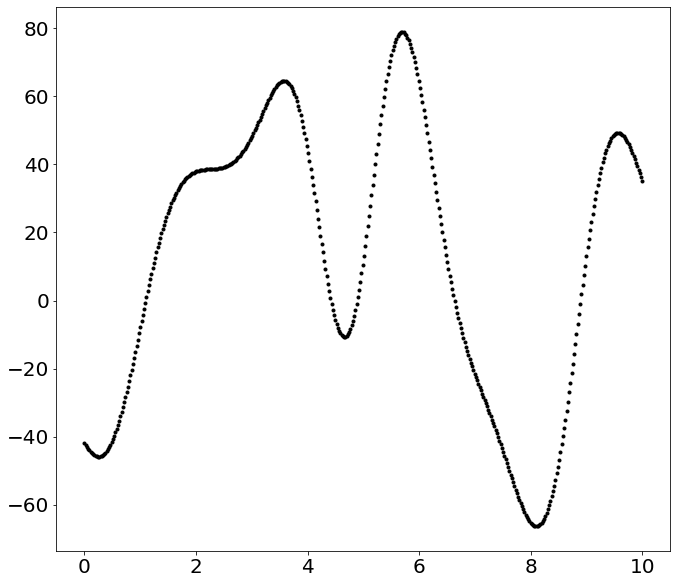

In [145]:
plt.plot(m.X, gmean, 'k.')

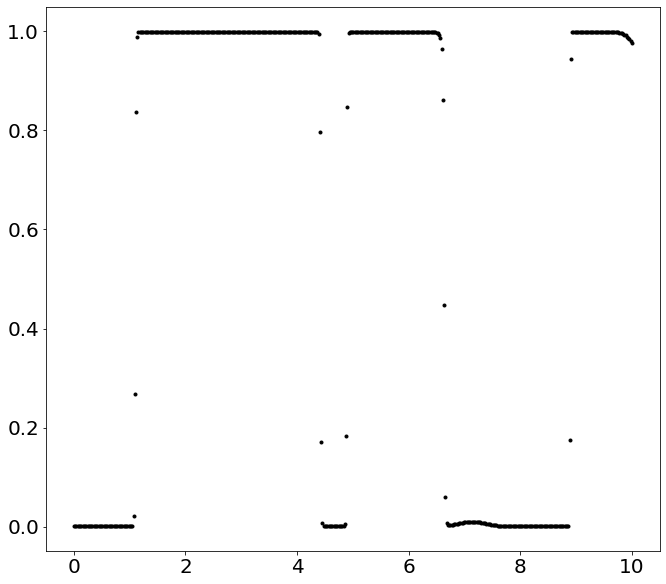

In [146]:
plt.plot(m.X, ephi_g, 'k.')

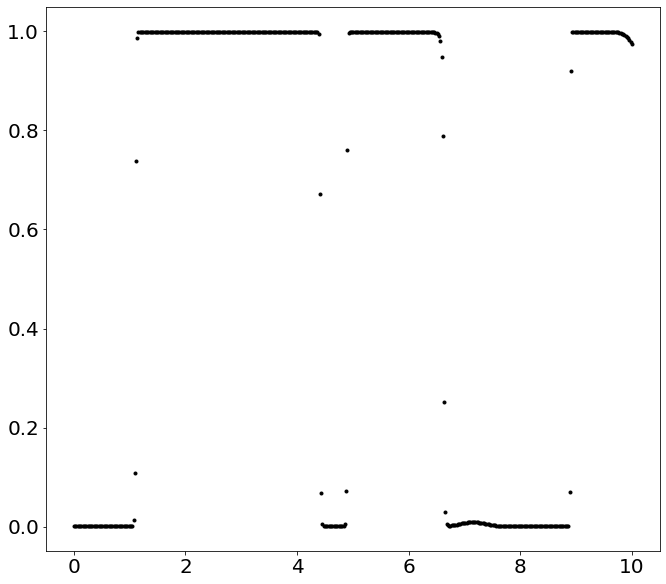

In [147]:
plt.plot(m.X, ephi2_g, 'k.')

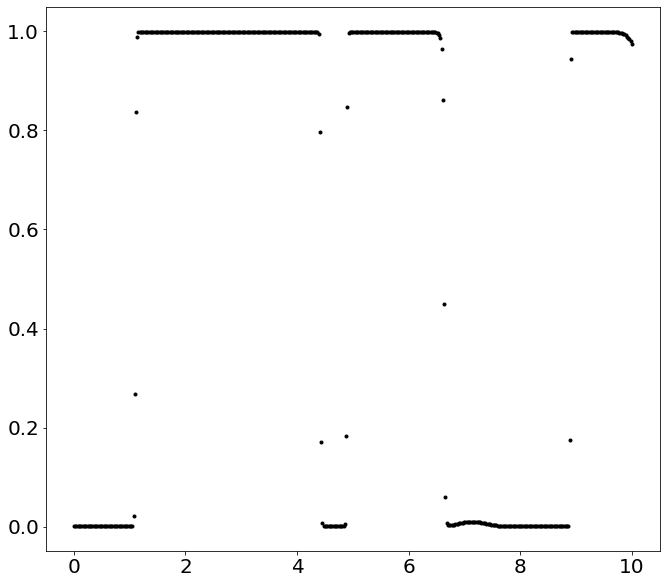

In [148]:
plt.plot(m.X, tf.reduce_mean(phi_g_samples,-1), 'k.')

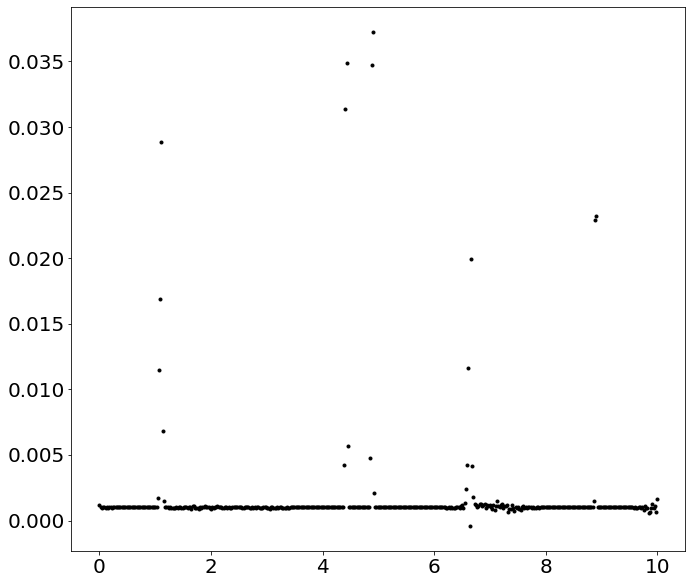

In [149]:
plt.plot(m.X, ephi2_g-tf.reduce_mean(phi_g_samples*phi_g_samples,-1), 'k.')

In [150]:
np.mean(ephi2_g-tf.reduce_mean(phi_g_samples*phi_g_samples,-1))

0.0016489289

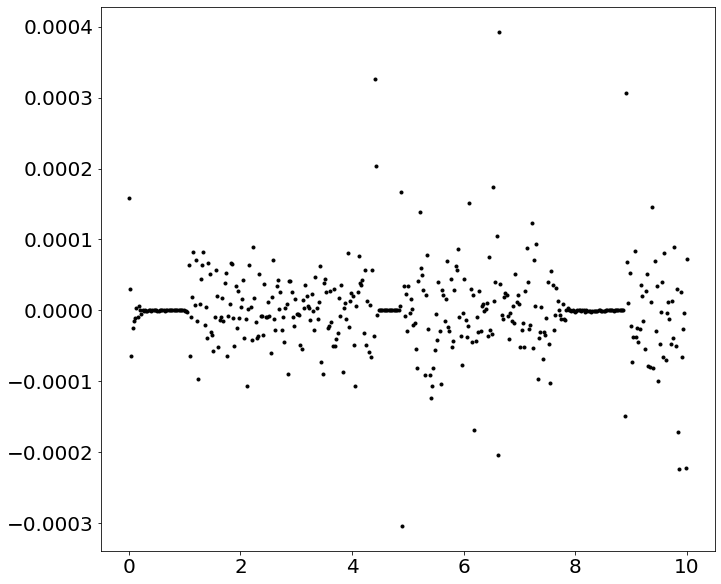

In [151]:
plt.plot(m.X, gfmean-tf.reduce_mean(f_samples,-1), 'k.')

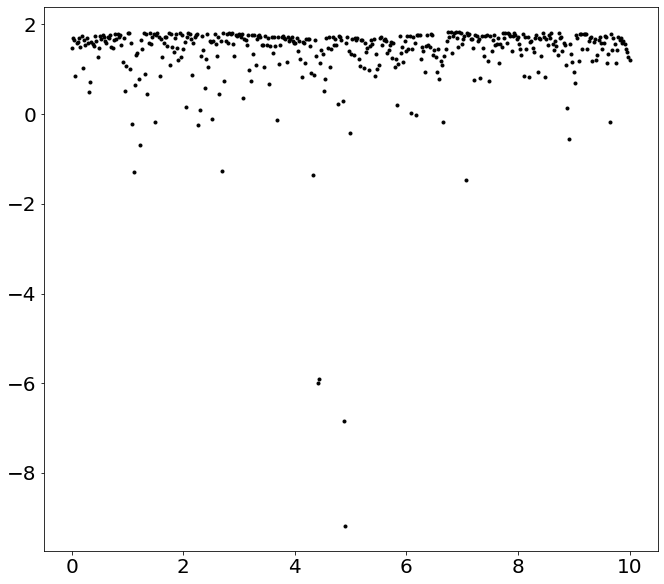

In [152]:
plt.plot(m.X, var_exp, 'k.')

Text(0.5, 1.0, 'Absolute Difference between analytic and MC estimate of p(y|f)')

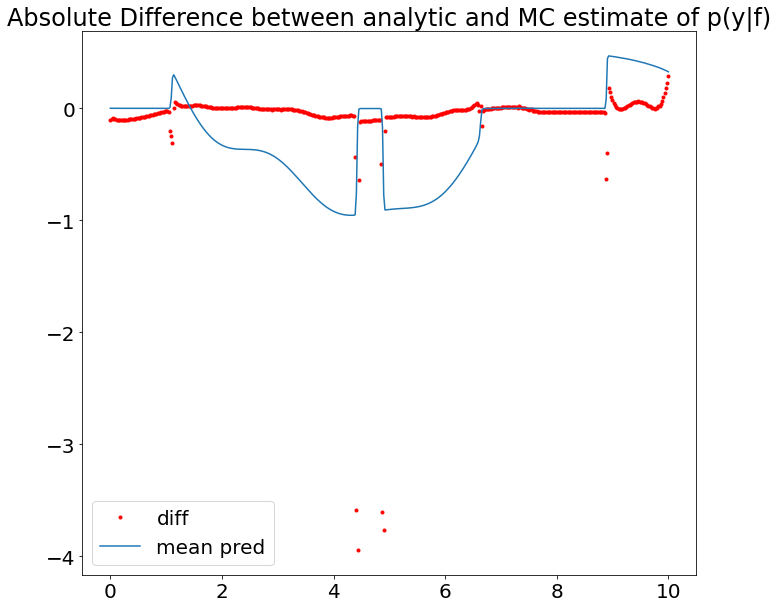

In [159]:
plt.plot(m.X, var_exp-elbo_likelihood_over_samples, 'r.', label='diff')
plt.plot(m.X, tf.reduce_mean(f_samples,-1), label='mean pred')
plt.legend()
plt.title('Absolute Difference between analytic and MC estimate of p(y|f)')

In [133]:
np.mean( var_exp-elbo_likelihood_over_samples)

-0.06151704

In [155]:
np.sum( var_exp-elbo_likelihood_over_samples)

-28.8233